In [3]:
import pandas as pd
#import evaluate
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROB7824\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove multiple whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words and perform stemming
    words = word_tokenize(text)
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    return ' '.join(filtered_words)

In [3]:
text_df = pd.read_csv("./df_file.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

texts = text_df['Text'].to_list()
labels = text_df['Label'].to_list()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess your texts here
preprocessed_texts = [preprocess_text(text) for text in texts]

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(preprocessed_texts, labels, test_size=0.2, random_state=43)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=43)

In [94]:
X_train_W2C = pd.DataFrame(X_train, columns=['Text'])

cnt = Counter()
for text in X_train_W2C['Text'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('the', 35701),
 ('to', 19858),
 ('of', 15861),
 ('and', 14387),
 ('a', 13698),
 ('in', 13238),
 ('for', 6883),
 ('is', 6792),
 ('that', 6058),
 ('on', 5815),
 ('The', 5721),
 ('was', 4810),
 ('be', 4604),
 ('with', 4096),
 ('said', 3939),
 ('has', 3889),
 ('it', 3875),
 ('have', 3812),
 ('as', 3671),
 ('will', 3528)]

In [85]:
from collections import Counter
cnt = Counter()
for text in X_train['Text'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('said', 5855),
 ('mr', 2421),
 ('year', 2316),
 ('would', 2122),
 ('also', 1758),
 ('peopl', 1685),
 ('new', 1606),
 ('us', 1530),
 ('one', 1452),
 ('game', 1335)]

In [4]:
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encode the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Create a custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset objects
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Load the DistilBert model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  3%|▎         | 10/333 [04:52<2:46:35, 30.95s/it]

{'loss': 1.6091, 'grad_norm': 1.705458641052246, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.09}


  6%|▌         | 20/333 [11:48<3:53:56, 44.84s/it]

{'loss': 1.612, 'grad_norm': 1.5743898153305054, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.18}


  9%|▉         | 30/333 [18:36<3:23:07, 40.22s/it]

{'loss': 1.5906, 'grad_norm': 1.5698498487472534, 'learning_rate': 3e-06, 'epoch': 0.27}


 12%|█▏        | 40/333 [24:22<2:45:22, 33.86s/it]

{'loss': 1.5845, 'grad_norm': 1.9252502918243408, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.36}


 15%|█▌        | 50/333 [29:46<2:35:31, 32.97s/it]

{'loss': 1.5577, 'grad_norm': 2.1481170654296875, 'learning_rate': 5e-06, 'epoch': 0.45}


 18%|█▊        | 60/333 [35:18<2:30:08, 33.00s/it]

{'loss': 1.512, 'grad_norm': 2.7123050689697266, 'learning_rate': 6e-06, 'epoch': 0.54}


 21%|██        | 70/333 [40:47<2:22:02, 32.40s/it]

{'loss': 1.4408, 'grad_norm': 3.0538902282714844, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.63}


 24%|██▍       | 80/333 [46:10<2:16:08, 32.29s/it]

{'loss': 1.3176, 'grad_norm': 3.5950918197631836, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.72}


 27%|██▋       | 90/333 [51:37<2:10:58, 32.34s/it]

{'loss': 1.1489, 'grad_norm': 3.901843309402466, 'learning_rate': 9e-06, 'epoch': 0.81}


 30%|███       | 100/333 [57:04<2:06:56, 32.69s/it]

{'loss': 1.0089, 'grad_norm': 3.7686874866485596, 'learning_rate': 1e-05, 'epoch': 0.9}


 33%|███▎      | 110/333 [1:02:31<1:59:31, 32.16s/it]

{'loss': 0.7858, 'grad_norm': 3.0647289752960205, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.99}


 36%|███▌      | 120/333 [1:07:40<2:05:39, 35.39s/it]

{'loss': 0.6533, 'grad_norm': 6.102105617523193, 'learning_rate': 1.2e-05, 'epoch': 1.08}


 39%|███▉      | 130/333 [1:13:29<2:00:56, 35.74s/it]

{'loss': 0.4995, 'grad_norm': 3.087615966796875, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.17}


 42%|████▏     | 140/333 [1:19:36<2:01:09, 37.67s/it]

{'loss': 0.4091, 'grad_norm': 1.8654491901397705, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.26}


 45%|████▌     | 150/333 [1:25:28<1:41:13, 33.19s/it]

{'loss': 0.313, 'grad_norm': 4.1947126388549805, 'learning_rate': 1.5e-05, 'epoch': 1.35}


 48%|████▊     | 160/333 [1:31:35<2:06:36, 43.91s/it]

{'loss': 0.2642, 'grad_norm': 6.108500003814697, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.44}


 51%|█████     | 170/333 [1:37:03<1:21:51, 30.13s/it]

{'loss': 0.2756, 'grad_norm': 4.469967365264893, 'learning_rate': 1.7000000000000003e-05, 'epoch': 1.53}


 54%|█████▍    | 180/333 [1:42:01<1:18:19, 30.72s/it]

{'loss': 0.226, 'grad_norm': 3.0970263481140137, 'learning_rate': 1.8e-05, 'epoch': 1.62}


 57%|█████▋    | 190/333 [1:46:53<1:10:51, 29.73s/it]

{'loss': 0.1387, 'grad_norm': 2.622821092605591, 'learning_rate': 1.9e-05, 'epoch': 1.71}


 60%|██████    | 200/333 [1:52:40<1:21:11, 36.62s/it]

{'loss': 0.1311, 'grad_norm': 4.556951522827148, 'learning_rate': 2e-05, 'epoch': 1.8}


 63%|██████▎   | 210/333 [1:58:23<1:09:33, 33.93s/it]

{'loss': 0.2246, 'grad_norm': 14.834507942199707, 'learning_rate': 2.1e-05, 'epoch': 1.89}


 66%|██████▌   | 220/333 [2:03:28<58:14, 30.93s/it]  

{'loss': 0.1625, 'grad_norm': 0.522847592830658, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.98}


 69%|██████▉   | 230/333 [2:08:40<57:41, 33.61s/it]  

{'loss': 0.1938, 'grad_norm': 7.616608619689941, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.07}


 72%|███████▏  | 240/333 [2:14:35<54:43, 35.31s/it]

{'loss': 0.1077, 'grad_norm': 3.5315492153167725, 'learning_rate': 2.4e-05, 'epoch': 2.16}


 75%|███████▌  | 250/333 [2:20:22<45:58, 33.24s/it]

{'loss': 0.1147, 'grad_norm': 0.3012600541114807, 'learning_rate': 2.5e-05, 'epoch': 2.25}


 78%|███████▊  | 260/333 [2:25:58<40:44, 33.49s/it]

{'loss': 0.1273, 'grad_norm': 6.788035869598389, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.34}


 81%|████████  | 270/333 [2:31:24<35:36, 33.91s/it]

{'loss': 0.028, 'grad_norm': 0.627873957157135, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.43}


 84%|████████▍ | 280/333 [2:37:20<30:58, 35.07s/it]

{'loss': 0.1261, 'grad_norm': 13.258627891540527, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.52}


 87%|████████▋ | 290/333 [2:43:10<25:26, 35.49s/it]

{'loss': 0.021, 'grad_norm': 0.2030424326658249, 'learning_rate': 2.9e-05, 'epoch': 2.61}


 90%|█████████ | 300/333 [2:48:52<19:00, 34.56s/it]

{'loss': 0.0396, 'grad_norm': 0.17045678198337555, 'learning_rate': 3e-05, 'epoch': 2.7}


 93%|█████████▎| 310/333 [2:54:25<12:11, 31.82s/it]

{'loss': 0.1083, 'grad_norm': 0.44459977746009827, 'learning_rate': 3.1e-05, 'epoch': 2.79}


 96%|█████████▌| 320/333 [2:59:52<07:23, 34.09s/it]

{'loss': 0.0946, 'grad_norm': 8.709884643554688, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.88}


 99%|█████████▉| 330/333 [3:05:37<01:42, 34.24s/it]

{'loss': 0.1137, 'grad_norm': 2.909803867340088, 'learning_rate': 3.3e-05, 'epoch': 2.97}


100%|██████████| 333/333 [3:06:52<00:00, 33.67s/it]

{'train_runtime': 11212.6679, 'train_samples_per_second': 0.471, 'train_steps_per_second': 0.03, 'train_loss': 0.5877340986385001, 'epoch': 3.0}


TrainOutput(global_step=333, training_loss=0.5877340986385001, metrics={'train_runtime': 11212.6679, 'train_samples_per_second': 0.471, 'train_steps_per_second': 0.03, 'total_flos': 700260131727360.0, 'train_loss': 0.5877340986385001, 'epoch': 3.0})

In [6]:
#path = "..\..\"

# Save the model and tokenizer to a directory
model.save_pretrained('..\Models\my_distilbert_model')
tokenizer.save_pretrained('..\Models\my_distilbert_tokenizer')

# Load the model and tokenizer from the saved directory
#model = DistilBertForSequenceClassification.from_pretrained('my_distilbert_model')
#tokenizer = DistilBertTokenizer.from_pretrained('my_distilbert_tokenizer')


('..\\Models\\my_distilbert_tokenizer\\tokenizer_config.json',
 '..\\Models\\my_distilbert_tokenizer\\special_tokens_map.json',
 '..\\Models\\my_distilbert_tokenizer\\vocab.txt',
 '..\\Models\\my_distilbert_tokenizer\\added_tokens.json')

In [7]:
# Create a custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [4]:
test_df = pd.read_csv("./TestDataUnseen.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

text = test_df['Text'].to_list()
test_labels = test_df['Label'].to_list()

# Load the model and tokenizer from the saved directory
model = DistilBertForSequenceClassification.from_pretrained('my_distilbert_model')
tokenizer = DistilBertTokenizer.from_pretrained('my_distilbert_tokenizer')


test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = TextDataset(test_encodings, test_labels)

# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)

from sklearn.metrics import classification_report

# Get predictions for the test set
predictions = trainer.predict(test_dataset)

# Convert predictions to numpy array for compatibility with sklearn
pred_labels = np.argmax(predictions.predictions, axis=1)

# Generate classification report
report = classification_report(test_labels, pred_labels)
print(report)


KeyError: 'Text'

In [12]:
test_df = pd.read_csv("./TestDataUnseen.csv", delimiter=';') #./df_file.csv, /content/drive/MyDrive/df_file.csv

texts = test_df['Text'].to_list()
test_labels = test_df['Label'].to_list()

test_texts = [preprocess_text(text) for text in texts]

# Load the model and tokenizer from the saved directory
model = DistilBertForSequenceClassification.from_pretrained('..\Models\my_distilbert_model')
tokenizer = DistilBertTokenizer.from_pretrained('..\Models\my_distilbert_tokenizer')

test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = TextDataset(test_encodings, test_labels)

from torch.utils.data import DataLoader
# Load the data into a DataLoader for batch processing
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculations for efficiency
with torch.no_grad():
    for batch in test_loader:
        # Forward pass, get the logits
        outputs = model(**batch)
        logits = outputs.logits
        
        # Convert logits to probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Get the predicted class labels
        preds = torch.argmax(probs, dim=1)
        
        # Store the predictions
        predictions.extend(preds.tolist())

from sklearn.metrics import classification_report
report = classification_report(test_labels, predictions) 
print(report)

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.60      0.75        10
           2       0.80      0.80      0.80        10
           3       0.67      0.80      0.73        10
           4       0.64      0.90      0.75        10

    accuracy                           0.76        50
   macro avg       0.80      0.76      0.76        50
weighted avg       0.80      0.76      0.76        50



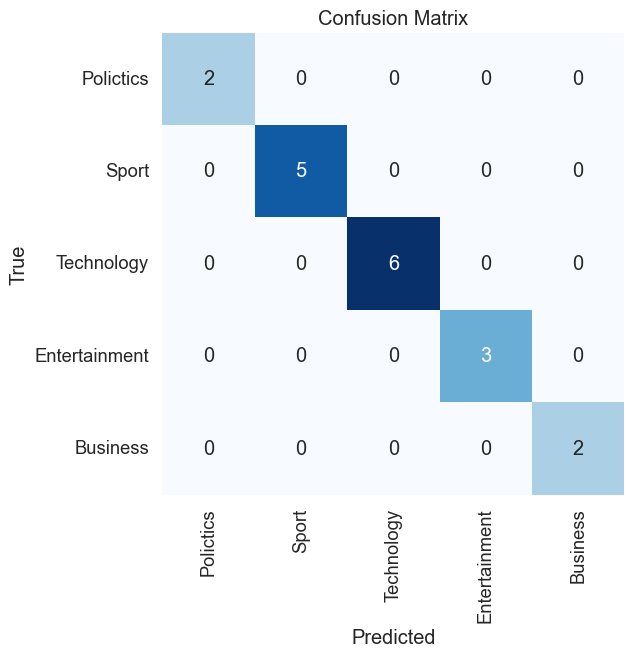

In [10]:

confusion = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"], yticklabels=["Polictics", "Sport", "Technology", "Entertainment", "Business"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Most frequent N-grams

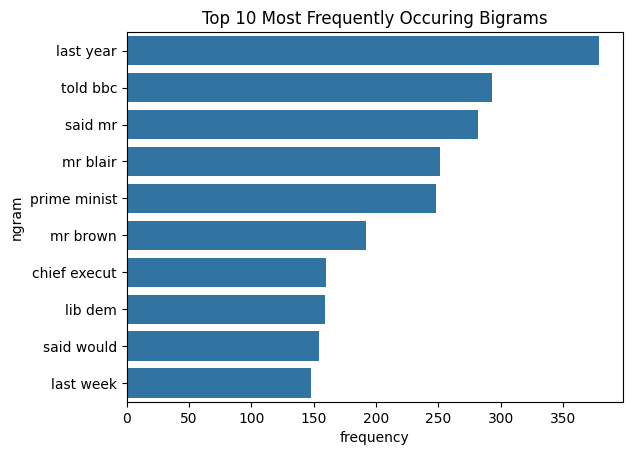

In [111]:
# Decoding Tokenized Text
decoded_texts = [tokenizer.decode(entry['input_ids'], skip_special_tokens=True) for entry in X_train]
readable_text = pd.DataFrame(decoded_texts, columns=['Text'])

# Checking most frequent Bi-grams
cv2 = CountVectorizer(ngram_range=(2,2))
bigrams = cv2.fit_transform(readable_text['Text'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv2.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

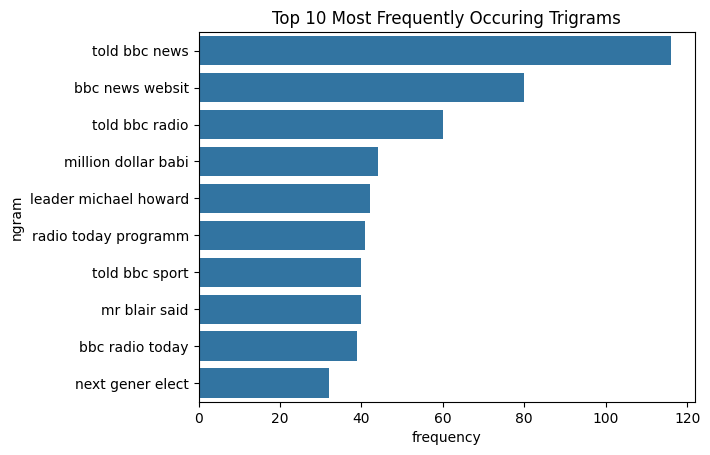

In [113]:
# Checking most frequent Tri-grams
cv3 = CountVectorizer(ngram_range=(3,3))
trigrams  = cv3.fit_transform(readable_text['Text'])

count_values = trigrams .toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv3.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

In [61]:
# Assuming X_test is a dictionary with 'input_ids' key
readable_text = tokenizer.decode(X_test[10]['input_ids'], skip_special_tokens=True)
print(readable_text)


blunkett row end blair prime minist toni blair said time draw line controversi surround david blunkett tori lib dem call second inquiri fasttrack visa applic mr blunkett exlov nanni sir alan budd found chain event link mr blunkett leoncia casalm indefinit leav remain applic end middl east trip mr blair said still admir mr blunkett thought integr intact tuesday sir alan said applic leav remain uk made kimberli quinn nanni process day day faster averag could find evid show whether mr blunkett intervent intend give special help lover nanni rais case exampl poor department perform first comment sinc sir alan announc mr blair told bbc news yet read report detail told bbc news far im concern drawn line ask mr blunkett could return frontlin polit point repli made admir david clear remain he tremend colleagu he done great job us first home secretari educ secretari futur someth approach futur prime minist shrug claim conserv leader michael howard led grubbi govern said mr blunkett integr remain